# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

###Not for Grading

## Implementing an MLP to understand the affect of "What neurons do?"

The objective of the experiment is to understand how the changes in layers of MLP affect the output.



#### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P18_test" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "912345678" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="M1W2_CS_7_What_neurons_do_" #name of the notebook

def setup():
    #ipython.magic("sx wget https://www.dropbox.com/s/vu7xkf6j3v9p5np/AIML_DS_REGR01_SIMPLEPENDULUMOSCILLATIONDATA.txt.zip?dl=1")
   # ipython.magic("sx unzip AIML_DS_REGR01_SIMPLEPENDULUMOSCILLATIONDATA.txt.zip?dl=1")
    #ipython.magic("sx pip install torch")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print("Please enter valid Id")
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful. Ref:", submission_id)
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


## Importing required packages for the experiment

In [0]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn.manifold import TSNE
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset we can play with. Here, we will use [scikit-learn](http://scikit-learn.org/) package which has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

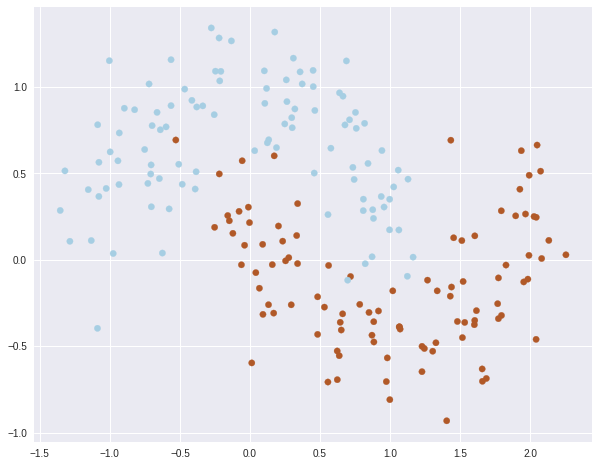

In [0]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Paired)

## Helper function to plot a decision boundary.

In [0]:

# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.BrBG)
    #plt.savefig('hidden_neuron_'+str(i))

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [0]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [0]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [0]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [0]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.603423
Loss after iteration 1000: 0.069201
Loss after iteration 2000: 0.071261
Loss after iteration 3000: 0.071348
Loss after iteration 4000: 0.071370
Loss after iteration 5000: 0.071380
Loss after iteration 6000: 0.071383
Loss after iteration 7000: 0.071383
Loss after iteration 8000: 0.071381
Loss after iteration 9000: 0.071377
Loss after iteration 10000: 0.071374
Loss after iteration 11000: 0.071370
Loss after iteration 12000: 0.071366
Loss after iteration 13000: 0.071363
Loss after iteration 14000: 0.071360
Loss after iteration 15000: 0.071357
Loss after iteration 16000: 0.071355
Loss after iteration 17000: 0.071352
Loss after iteration 18000: 0.071350
Loss after iteration 19000: 0.071348


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

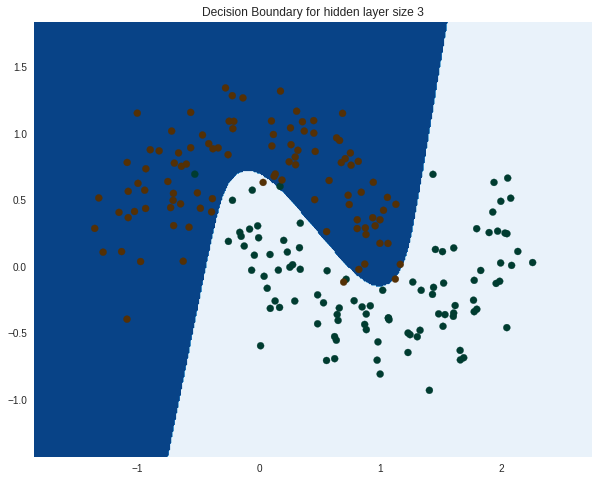

In [0]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Here, our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


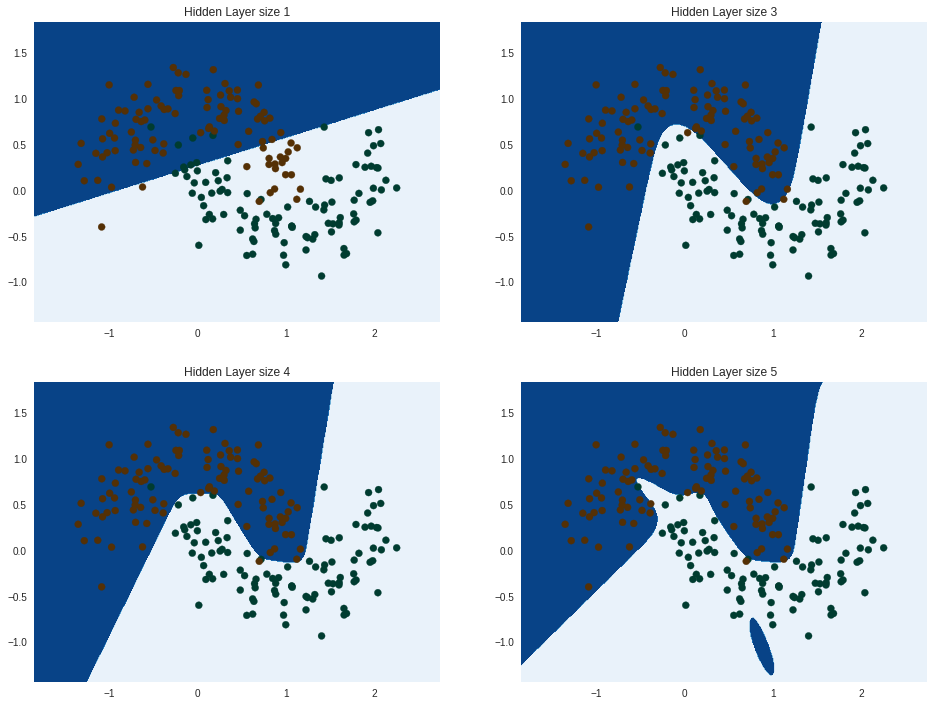

In [0]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 3, 4, 5]
models=[]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    models.append(model)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

As the number of neurons in the hidden increases the complexity of the decision boundary increases and we can visualize in the following plots

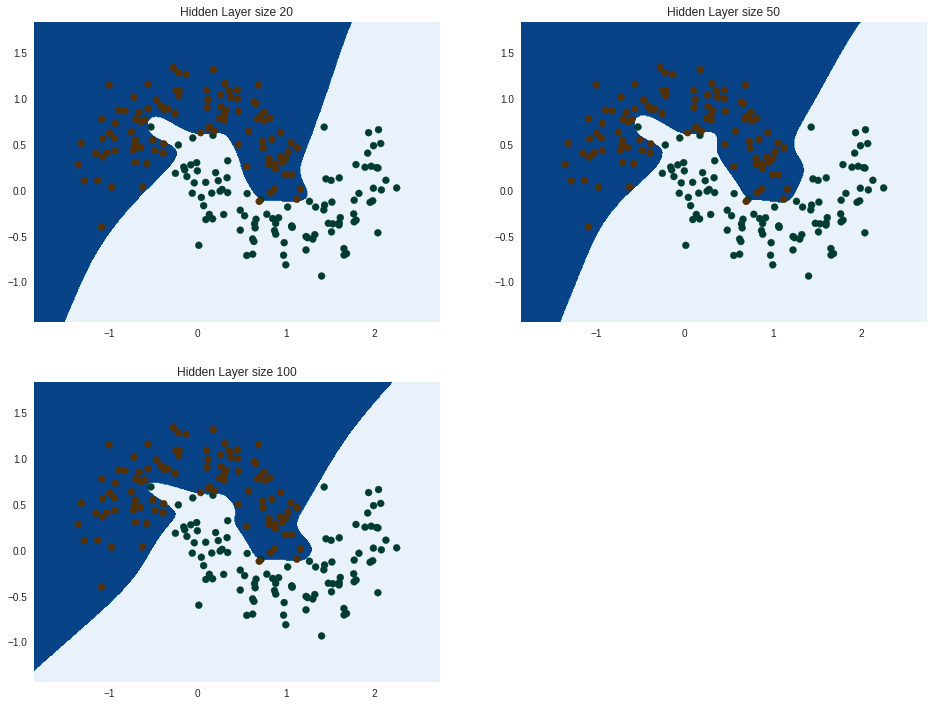

In [0]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [20, 50, 100]
models=[]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    models.append(model)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()